## 0. Environment & Dependencies

Load required libraries for preprocessing, modeling, visualization, and evaluation plus shared constants for reproducibility.


In [27]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
    brier_score_loss,
)

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

RANDOM_STATE = 42
TOPK_RATIO = 0.1


## 1. Load Data

Read the cleaned churn dataset and confirm the head looks correct.


In [28]:
DATA_PATH = Path('churn_clean.csv')
assert DATA_PATH.exists(), f"Data file not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 2. Prepare Features & Target

Split out the `Exited` target and record categorical/numeric column names for preprocessing.


In [29]:
X = df.drop('Exited', axis=1)
y = df['Exited']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()
cat_cols, num_cols


(['Geography', 'Gender'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'])

## 3. Metric Helpers

Common Precision@K/Recall@K helper and a unified evaluation function for all models.


In [30]:
def topk_precision_recall(y_true, y_proba, k_ratio: float = TOPK_RATIO):
    """Compute Precision@K and Recall@K."""
    assert 0 < k_ratio <= 1, 'k_ratio must be in (0, 1].'
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    n = len(y_true)
    k = max(1, int(np.floor(n * k_ratio)))
    order = np.argsort(-y_proba)
    topk_idx = order[:k]

    y_topk = y_true[topk_idx]
    tp_at_k = y_topk.sum()
    total_pos = y_true.sum()

    precision_at_k = tp_at_k / k
    recall_at_k = tp_at_k / total_pos if total_pos > 0 else 0.0

    return {
        'K': k,
        'Precision@K': precision_at_k,
        'Recall@K': recall_at_k,
    }


def evaluate_classifier(y_true, y_proba, threshold: float = 0.5, k_ratio: float = TOPK_RATIO):
    """Return ROC-AUC, PR-AUC, F1, Balanced Accuracy, Brier Score, Precision@K/Recall@K."""
    y_true_arr = y_true.values if hasattr(y_true, 'values') else np.asarray(y_true)
    y_proba_arr = np.asarray(y_proba)
    y_pred = (y_proba_arr >= threshold).astype(int)

    metrics = {
        'ROC-AUC': roc_auc_score(y_true_arr, y_proba_arr),
        'PR-AUC': average_precision_score(y_true_arr, y_proba_arr),
        'F1': f1_score(y_true_arr, y_pred),
        'BalancedAccuracy': balanced_accuracy_score(y_true_arr, y_pred),
        'BrierScore': brier_score_loss(y_true_arr, y_proba_arr),
    }

    topk = topk_precision_recall(y_true_arr, y_proba_arr, k_ratio=k_ratio)
    metrics.update(topk)
    return metrics


## 4. 60/20/20 Split

Perform stratified splits to keep class balance uniform across train, validation, and test sets.


In [31]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=RANDOM_STATE,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE,
)

print('Train:', X_train.shape, 'Target ratio:', y_train.mean().round(3))
print('Validation:', X_val.shape, 'Target ratio:', y_val.mean().round(3))
print('Test:', X_test.shape, 'Target ratio:', y_test.mean().round(3))


Train: (6000, 10) Target ratio: 0.204
Validation: (2000, 10) Target ratio: 0.204
Test: (2000, 10) Target ratio: 0.204


## 5. Preprocessing & XGBoost Pipeline

One-hot encode categorical features, standardize numeric ones, and attach an XGBoost classifier with class weighting.


In [32]:
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer([
    ('categorical', ohe, cat_cols),
    ('numeric', StandardScaler(), num_cols)
])

xgb_params = dict(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=1500,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=float((1 - y_train.mean()) / y_train.mean()),
    tree_method='hist',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

xgb_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', XGBClassifier(**xgb_params))
])
xgb_pipeline


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 6. Train The XGBoost Model

Fit the pipeline on the training split using the validation set for monitoring.


In [33]:
xgb_pipeline.named_steps['model'].set_params(verbosity=0)
xgb_pipeline.fit(X_train, y_train)
xgb_pipeline



,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 7. Generate Validation/Test Predictions

Store label predictions and probabilities for downstream metrics and plots.


In [34]:
predictions = {}
for dataset_name, (X_split, y_split) in {
    'Validation': (X_val, y_val),
    'Test': (X_test, y_test),
}.items():
    y_pred = xgb_pipeline.predict(X_split)
    y_proba = xgb_pipeline.predict_proba(X_split)[:, 1]
    predictions[dataset_name] = {
        'y_true': y_split,
        'y_pred': y_pred,
        'y_proba': y_proba,
    }

predictions


{'Validation': {'y_true': 8583    0
  1924    0
  3195    0
  5263    0
  1484    0
         ..
  926     0
  6727    1
  4745    1
  1307    0
  7464    1
  Name: Exited, Length: 2000, dtype: int64,
  'y_pred': array([0, 0, 0, ..., 1, 0, 1], shape=(2000,)),
  'y_proba': array([0.02490359, 0.2015222 , 0.00257337, ..., 0.9403549 , 0.0254092 ,
         0.50469804], shape=(2000,), dtype=float32)},
 'Test': {'y_true': 9167    0
  9387    0
  6859    0
  3500    0
  6233    0
         ..
  7392    0
  3233    0
  218     1
  4755    0
  7634    0
  Name: Exited, Length: 2000, dtype: int64,
  'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(2000,)),
  'y_proba': array([0.00696342, 0.10958844, 0.02762743, ..., 0.07192366, 0.15255812,
         0.02853863], shape=(2000,), dtype=float32)}}

## 8. Aggregate Key Metrics

Summarize ROC-AUC, PR-AUC, F1, Balanced Accuracy, Brier Score, and Top-K stats per split.


In [35]:
metrics_rows = []
for dataset_name, values in predictions.items():
    metrics = evaluate_classifier(values['y_true'], values['y_proba'], k_ratio=TOPK_RATIO)
    metrics_rows.append({'Dataset': dataset_name, **metrics})

metrics_df = pd.DataFrame(metrics_rows)
metrics_df


,Dataset,ROC-AUC,PR-AUC,F1,BalancedAccuracy,BrierScore,K,Precision@K,Recall@K
0,Validation,0.846569,0.658728,0.592417,0.747955,0.124938,200,0.765,0.375000
1,Test,0.830448,0.650080,0.562728,0.726345,0.127767,200,0.755,0.371007


## 9. Classification Reports & Confusion Matrices

Print classification reports and retain confusion matrices for plotting.


In [36]:
conf_matrices = {}
for dataset_name, values in predictions.items():
    cm = confusion_matrix(values['y_true'], values['y_pred'])
    conf_matrices[dataset_name] = cm
    print(f"XGBoost - {dataset_name} classification report")
    print(classification_report(values['y_true'], values['y_pred']))

conf_matrices


XGBoost - Validation classification report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1592
           1       0.57      0.61      0.59       408

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000

XGBoost - Test classification report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1593
           1       0.56      0.57      0.56       407

    accuracy                           0.82      2000
   macro avg       0.72      0.73      0.72      2000
weighted avg       0.82      0.82      0.82      2000



{'Validation': array([[1406,  186],
        [ 158,  250]]),
 'Test': array([[1410,  183],
        [ 176,  231]])}

## 10. Figure Output Directory

Ensure the shared figure directory exists before saving plots.


In [37]:
FIG_DIR = Path('figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)


## 11. Compute ROC/PR Curve Data

Capture FPR/TPR and Precision/Recall arrays plus AUC/AP values for both splits.


In [38]:
curve_data = {}
for dataset_name, values in predictions.items():
    fpr, tpr, _ = roc_curve(values['y_true'], values['y_proba'])
    prec, rec, _ = precision_recall_curve(values['y_true'], values['y_proba'])
    auc = roc_auc_score(values['y_true'], values['y_proba'])
    ap = average_precision_score(values['y_true'], values['y_proba'])
    curve_data[dataset_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'precision': prec,
        'recall': rec,
        'auc': auc,
        'ap': ap,
    }
curve_data


{'Validation': {'fpr': array([0.        , 0.        , 0.        , 0.00125628, 0.00125628,
         0.00188442, 0.00188442, 0.00251256, 0.00251256, 0.0031407 ,
         0.0031407 , 0.00376884, 0.00376884, 0.00439698, 0.00439698,
         0.00502513, 0.00502513, 0.00565327, 0.00565327, 0.00690955,
         0.00690955, 0.00753769, 0.00753769, 0.00816583, 0.00816583,
         0.00942211, 0.00942211, 0.01067839, 0.01067839, 0.01130653,
         0.01130653, 0.01256281, 0.01256281, 0.01319095, 0.01319095,
         0.0138191 , 0.0138191 , 0.01444724, 0.01444724, 0.01570352,
         0.01570352, 0.01633166, 0.01633166, 0.0169598 , 0.0169598 ,
         0.01758794, 0.01758794, 0.01821608, 0.01821608, 0.01884422,
         0.01884422, 0.02072864, 0.02072864, 0.02135678, 0.02135678,
         0.02198492, 0.02198492, 0.02386935, 0.02386935, 0.02449749,
         0.02449749, 0.02512563, 0.02512563, 0.02638191, 0.02638191,
         0.02701005, 0.02701005, 0.02826633, 0.02826633, 0.02889447,
         0.02

## 12. Plot ROC Curves

Overlay validation/test ROC curves to evaluate generalization.


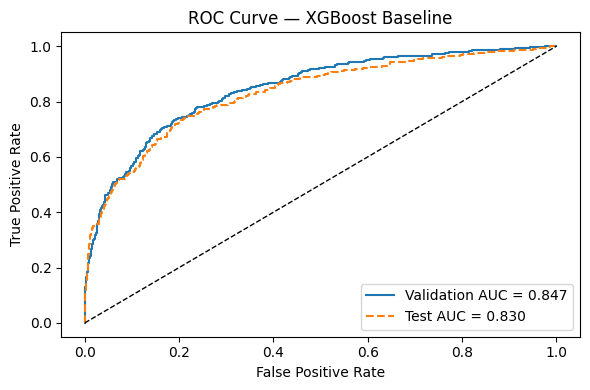

In [39]:
plt.figure(figsize=(6, 4))
for dataset_name, roc_info in curve_data.items():
    linestyle = '-' if dataset_name == 'Validation' else '--'
    plt.plot(roc_info['fpr'], roc_info['tpr'], linestyle=linestyle, label=f"{dataset_name} AUC = {roc_info['auc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — XGBoost Baseline')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve_xgb_baseline.png', dpi=200)
plt.show()


## 13. Plot Precision-Recall Curves

View recall–precision trade-offs for each split.


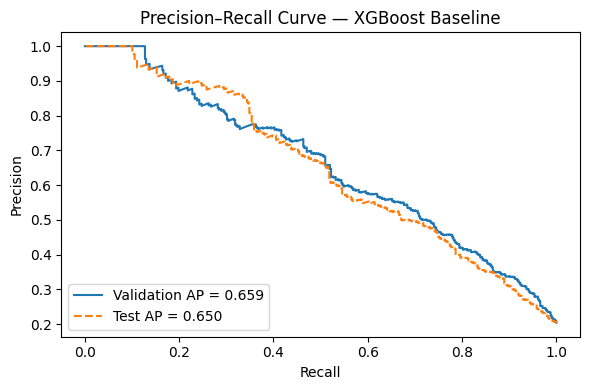

In [40]:
plt.figure(figsize=(6, 4))
for dataset_name, pr_info in curve_data.items():
    linestyle = '-' if dataset_name == 'Validation' else '--'
    plt.plot(pr_info['recall'], pr_info['precision'], linestyle=linestyle, label=f"{dataset_name} AP = {pr_info['ap']:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve — XGBoost Baseline')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(FIG_DIR / 'pr_curve_xgb_baseline.png', dpi=200)
plt.show()


## 14. Plot Confusion Matrices

Heatmaps for validation and test confusion matrices to inspect misclassification patterns.


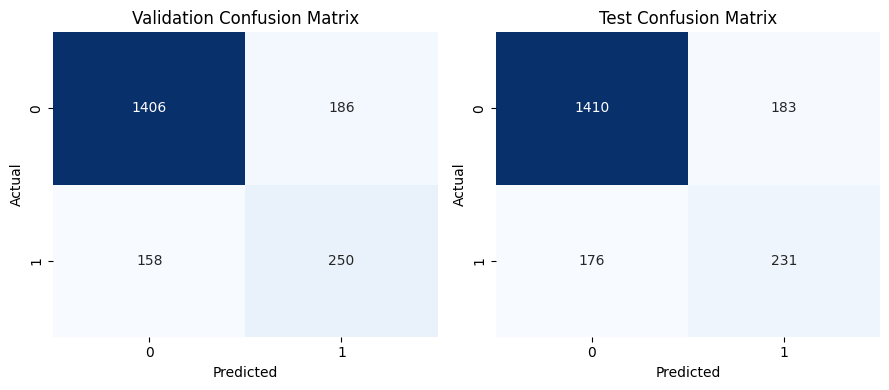

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for ax, dataset_name in zip(axes, ['Validation', 'Test']):
    sns.heatmap(conf_matrices[dataset_name], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{dataset_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrices_xgb_baseline.png', dpi=200)
plt.show()


## 15. Feature Importances

Inspect the top gain-based feature importances from XGBoost.


In [42]:
feature_names = xgb_pipeline.named_steps['preprocess'].get_feature_names_out()
importances = pd.Series(xgb_pipeline.named_steps['model'].feature_importances_, index=feature_names)
top_features = importances.sort_values(ascending=False).head(20)
top_features


numeric__NumOfProducts            0.248582
numeric__IsActiveMember           0.101796
categorical__Geography_Germany    0.100831
numeric__Age                      0.094316
numeric__Balance                  0.060718
categorical__Gender_Male          0.055776
categorical__Gender_Female        0.054538
categorical__Geography_Spain      0.052106
categorical__Geography_France     0.051499
numeric__EstimatedSalary          0.050205
numeric__CreditScore              0.047504
numeric__Tenure                   0.043626
numeric__HasCrCard                0.038503
dtype: float32

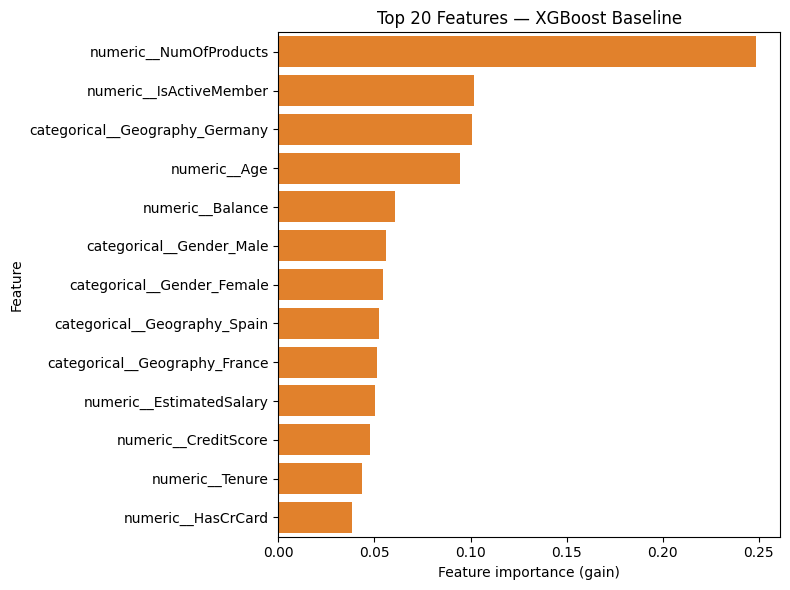

In [43]:
plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, color='tab:orange')
plt.xlabel('Feature importance (gain)')
plt.ylabel('Feature')
plt.title('Top 20 Features — XGBoost Baseline')
plt.tight_layout()
plt.show()


## 16. Export Metrics & Predictions

Write the aggregated metrics and per-sample prediction probabilities to CSV.


In [44]:
OUTPUT_DIR = Path('reports')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

metrics_df.to_csv(OUTPUT_DIR / 'xgboost_metrics_en.csv', index=False)

pred_rows = []
for dataset_name, values in predictions.items():
    pred_rows.append(pd.DataFrame({
        'dataset': dataset_name,
        'y_true': values['y_true'].values,
        'y_proba': values['y_proba'],
    }))
pred_df = pd.concat(pred_rows, ignore_index=True)
pred_df.to_csv(OUTPUT_DIR / 'xgboost_predictions_en.csv', index=False)

print('Saved metrics and predictions to', OUTPUT_DIR)


Saved metrics and predictions to reports


## 17. Persist The Trained Pipeline

Save the entire XGBoost pipeline (preprocessing + model) as a joblib artifact.


In [45]:
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / 'xgboost_baseline.joblib'
joblib.dump(xgb_pipeline, MODEL_PATH)
MODEL_PATH


PosixPath('models/xgboost_baseline.joblib')